In [39]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
# from torch_geometric.data import HeteroData

In [40]:
# Using GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [41]:
music = pd.read_csv("music.csv")
music.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [89]:
print(music.shape[0])
music.info()

9989
<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          9989 non-null   float64
 1   artist.id                  9989 non-null   object 
 2   artist.name                9989 non-null   object 
 3   artist_mbtags_count        9989 non-null   float64
 4   bars_confidence            9989 non-null   float64
 5   bars_start                 9989 non-null   float64
 6   beats_confidence           9989 non-null   float64
 7   beats_start                9989 non-null   float64
 8   duration                   9989 non-null   float64
 9   end_of_fade_in             9989 non-null   float64
 10  familiarity                9989 non-null   float64
 11  key                        9989 non-null   float64
 12  key_confidence             9989 non-null   float64
 13  latitude                   9989 non-null   float

### Data Cleaning

In [43]:
print(music[music.isna().any(axis=1)].shape[0])
music[music.isna().any(axis=1)].head(5)

7717


,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [44]:
music = music.drop(columns=['artist_mbtags','song.hotttnesss'])
music[music.isna().any(axis=1)]
print(music.shape[0])

10000


In [45]:

music = music.dropna()
music[music.isna().any(axis=1)]
print(music.shape[0])
music.describe()

9989


,artist.hotttnesss,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,familiarity,key,...,mode_confidence,release.id,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms_freq,time_signature,time_signature_confidence,year
count,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,...,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
mean,0.385795,0.524377,0.238799,1.065584,0.614011,0.434599,238.467081,0.756694,0.565595,5.277005,...,0.477849,370959.001702,229.934028,0.506941,0.299981,122.914981,0.969179,3.564521,0.509906,935.733907
std,0.143408,0.880489,0.275170,1.724314,0.322405,0.533870,113.999888,1.859318,0.160099,3.553675,...,0.191156,236653.830171,112.052246,0.320806,0.511181,35.187799,0.049379,1.266844,0.373432,996.716226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.044440,0.000000,0.000000,0.000000,...,0.000000,63.000000,1.044000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.325736,0.000000,0.035000,0.441730,0.410000,0.194660,175.986490,0.000000,0.467759,2.000000,...,0.360000,172858.000000,168.855000,0.237000,0.110710,96.967000,0.947629,3.000000,0.097000,0.000000
50%,0.380756,0.000000,0.120000,0.785640,0.686000,0.332560,223.059140,0.199000,0.563750,5.000000,...,0.487000,333103.000000,213.879000,0.500000,0.191490,120.160000,0.999973,4.000000,0.551000,0.000000
75%,0.454160,1.000000,0.351000,1.224300,0.882000,0.500760,276.375060,0.421000,0.668020,8.000000,...,0.606000,573496.000000,266.304000,0.774000,0.294740,144.005000,1.000000,4.000000,0.864000,2000.000000
max,1.082503,9.000000,1.000000,59.743540,1.000000,12.245830,1819.767710,43.119000,1.000000,11.000000,...,1.000000,823599.000000,1813.426000,1.000000,12.245830,262.828000,1.000000,7.000000,1.000000,2010.000000


In [46]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          9989 non-null   float64
 1   artist.id                  9989 non-null   object 
 2   artist.name                9989 non-null   object 
 3   artist_mbtags_count        9989 non-null   float64
 4   bars_confidence            9989 non-null   float64
 5   bars_start                 9989 non-null   float64
 6   beats_confidence           9989 non-null   float64
 7   beats_start                9989 non-null   float64
 8   duration                   9989 non-null   float64
 9   end_of_fade_in             9989 non-null   float64
 10  familiarity                9989 non-null   float64
 11  key                        9989 non-null   float64
 12  key_confidence             9989 non-null   float64
 13  latitude                   9989 non-null   float64
 1

### Model Selection

In [101]:
drop_cols = ['artist.id', 'artist.name', 'location', 'release.id', 'release.name', 
             'similar', 'song.id', 'title']
music_numeric = music.drop(columns=drop_cols)

# Save music_numeric to a csv file
music_numeric.to_csv("music_numeric.csv", index=False)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [64]:
music_numeric[:10]

,artist.hotttnesss,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,familiarity,key,...,mode_confidence,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,year
0,0.401998,0.0,0.643,0.58521,0.834,0.58521,218.93179,0.247,0.581794,1.0,...,0.636,218.932,0.779,0.28519,92.198,26,1.000000,4.0,0.778,0
2,0.343428,0.0,0.980,0.73152,0.980,0.73152,177.47546,0.282,0.487357,8.0,...,0.565,172.304,0.482,0.42132,100.070,42,1.000000,1.0,0.000,0
3,0.454231,1.0,0.017,1.30621,0.809,0.81002,233.40363,0.000,0.630382,0.0,...,0.749,217.124,0.601,0.56254,119.293,34,0.988584,4.0,0.000,1982
5,0.385471,0.0,0.121,1.17118,0.438,0.74856,267.70240,2.264,0.535293,5.0,...,0.557,254.270,0.136,0.53929,147.782,46,1.000000,3.0,0.454,0
7,0.605507,0.0,0.142,0.65428,0.234,0.65428,189.57016,0.319,0.801136,4.0,...,0.160,181.023,0.292,0.36129,101.430,36,0.999818,3.0,0.408,0
11,0.351556,0.0,0.018,1.45439,1.000,0.42896,245.21098,0.357,0.545159,7.0,...,0.686,227.480,0.728,0.17270,117.975,6,1.000000,4.0,0.835,0
13,0.251937,0.0,1.000,0.46223,1.000,0.46223,191.84281,0.380,0.085512,10.0,...,0.198,188.424,0.774,0.23506,137.334,7,0.977115,1.0,0.319,0
15,0.447935,2.0,0.507,1.32118,0.000,0.30065,491.12771,0.000,0.636424,7.0,...,0.829,486.034,0.377,0.05047,119.826,12,1.000000,4.0,0.756,1987
16,0.330806,0.0,0.125,1.19076,0.768,0.24795,228.59710,0.223,0.419943,8.0,...,0.516,217.426,0.767,0.08584,127.756,8,0.830058,5.0,0.579,0
18,0.513463,0.0,0.030,0.87520,1.000,0.05728,290.29832,0.145,0.707200,7.0,...,0.756,285.605,0.238,0.05728,150.062,23,1.000000,4.0,0.931,2004


In [96]:
# Keep the top 50 genres
top_genres = music_numeric['terms'].value_counts().index[:100]
music_numeric = music_numeric[music_numeric['terms'].isin(top_genres)]
print(f"Unique genres after filtering: {np.unique(music_numeric['terms'])}")

Unique genres after filtering: ['alternative metal' 'ballad' 'bhangra' 'black metal' 'blue-eyed soul'
 'bluegrass' 'blues' 'blues-rock' 'bossa nova' 'brazilian pop music'
 'breakbeat' 'brill building pop' 'british pop' 'cantonese pop' 'ccm'
 'chamber jazz' 'chanson' 'chicago blues' 'chicago soul' 'chill-out'
 'chinese music' 'comedy' 'country' 'country blues' 'country gospel'
 'country rock' 'cumbia' 'dance pop' 'dance rock' 'dancehall'
 'delta blues' 'disco' 'doo-wop' 'dubstep' 'easy listening' 'europop'
 'experimental rock' 'flamenco' 'folk rock' 'folk-pop' 'free jazz'
 'future jazz' 'gangster rap' 'ghetto tech' 'glam rock' 'grunge'
 'happy hardcore' 'hard house' 'hard rock' 'hard trance' 'hardcore punk'
 'heartland rock' 'heavy metal' 'hip hop' 'honky tonk' 'indie rock'
 'instrumental pop' 'irish folk' 'jazz funk' 'latin jazz' 'los angeles'
 'lovers rock' 'lullaby' 'meditation' 'modern rock' 'new wave' 'oi'
 'opera' 'orchestra' 'pop folk' 'pop rap' 'pop rock' 'post-grunge'
 'post-ha

In [97]:
print("Rows with year = 0:", (music_numeric['year'] == 0).sum())
print("Total rows:", music_numeric.shape[0])

Rows with year = 0: 3435
Total rows: 6672


In [98]:
# encode terms to numeric
label_encoder = LabelEncoder()
music_numeric['terms'] = label_encoder.fit_transform(music_numeric['terms'])

X_numeric = music_numeric.drop(columns=['terms'])
y_numeric = music_numeric['terms']

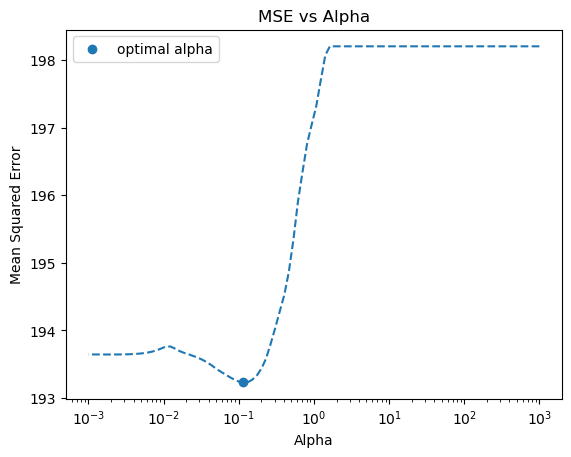

Optimal alpha (Lasso): 0.11497569953977356


In [62]:
X_train, X_test , y_train, y_test = train_test_split(X_numeric, y_numeric, test_size=0.3, random_state=1)

# Fit the transformer only on the training set 
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

# Range of alphas (follow log: 0.001 - 1000 normally)
alphas = np.logspace(-3, 3, 100)

# Lasso Cross-validation, 10 folds
lassocv = LassoCV(cv=10, 
                  alphas=alphas, 
                  max_iter=10000, 
                  tol=1e-4, 
                  random_state=404)
lassocv.fit(X_train_norm, y_train)

# mean MSE across folds for each alpha
mse_mean = np.mean(lassocv.mse_path_, axis=1)

# MSE versus alphas
plt.plot(lassocv.alphas_, mse_mean, linestyle='--')
plt.scatter(lassocv.alpha_, mse_mean[np.argmin(mse_mean)], label='optimal alpha')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.legend()
plt.show()

print('Optimal alpha (Lasso):', lassocv.alpha_)

In [63]:
# Lasso Coefficients
lasso_coefficients = pd.DataFrame({
    'feature': X_numeric.columns,
    'coefficient': lassocv.coef_
})

nonzero_features = lasso_coefficients[lasso_coefficients['coefficient'] != 0]
nonzero_features

,feature,coefficient
0,artist.hotttnesss,-0.187965
1,artist_mbtags_count,-0.908478
2,bars_confidence,-0.474842
3,bars_start,-0.296003
5,beats_start,0.320431
8,familiarity,0.725847
9,key,0.052817
11,latitude,-1.259628
13,loudness,-0.962865
14,mode,-0.709558


### Logistic Regression (Baseline)

In [99]:
# Without Lasso
X = music_numeric.drop(columns=['terms'])
y = music_numeric['terms']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

print(X_train.shape)
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)


(4670, 24)


In [81]:
# With Lasso
select_col = lasso_coefficients[lasso_coefficients['coefficient'] != 0]['feature'].to_list()
X = music_numeric[select_col]
y = music_numeric['terms']

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

print(X_train.shape)
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)
log_reg.predict_proba(X_test_norm)



(3349, 15)


/research/cvl-lehoang2/anaconda3/envs/CSE404/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[1.14072871e-02, 1.40839423e-02, 7.23666637e-02, ...,
        2.18146565e-03, 1.92474591e-03, 2.10019234e-03],
       [3.43628793e-03, 7.18817910e-03, 4.46998388e-03, ...,
        4.20875046e-02, 1.18063065e-02, 1.83785936e-03],
       [1.11206400e-01, 6.00357920e-02, 5.57557248e-04, ...,
        7.85342882e-04, 5.53440803e-03, 5.01557184e-05],
       ...,
       [1.42786649e-02, 4.09733180e-03, 4.79976770e-03, ...,
        1.10817171e-03, 3.64988068e-03, 2.88228223e-03],
       [5.36527933e-02, 1.81229136e-01, 1.63767091e-02, ...,
        3.27756036e-04, 2.89911638e-03, 9.03057639e-05],
       [9.38614886e-04, 2.01924830e-03, 9.18649533e-03, ...,
        8.96158872e-03, 5.69812513e-03, 1.55927510e-02]], shape=(1436, 50))

---

In [100]:
y_pred = log_reg.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1528


/research/cvl-lehoang2/anaconda3/envs/CSE404/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [67]:
# All the unique classes
unique_classes = np.unique(y)
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


#### Graph Neural Networks

##### Graph Structure

<div>
<img src="media/graph.jpg" width="500"/>
</div>

In [55]:
# These will be the three key identifiers
song_id_map = {sid: i for i, sid in enumerate(list(music['song.id']))}                  # There can only be one song
artist_id_map = {aid: i for i, aid in enumerate(list(music['artist.id'].unique()))}     # They can be under the same artist
release_id_map = {aid: i for i, aid in enumerate(list(music['release.id'].unique()))}   # They can be under the same release

# Tags
tag_id_map = {tid: i for i, tid in enumerate(list(music['terms'].unique()))}

In [56]:
### SONG NODE ###
song_features = ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
    'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence']

num_songs = len(music['song.id'])
num_song_feats = len(song_features)
song_x = np.zeros((num_songs, num_song_feats), dtype=np.float32)

for i, sid in enumerate(music['song.id']):
    row = music.loc[music['song.id'] == sid].iloc[0]
    song_x[i] = row[song_features].values
    
song_x = torch.tensor(song_x, dtype=torch.float32)

In [57]:
### TODO: ARTIST NODE ###

In [58]:
### TODO: RELEASE NODE ###

In [59]:
### TODO: BUILD EDGES ###